In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon

In [27]:
subs = ['sub-01','sub-02', 'sub-03','sub-04', 'sub-05', 'sub-06']
ft_models = ['conv4', 'conv5', 'conv6', 'conv7', 'no']
atlas = ['wholebrain', 'STG']
baseline = 'no'

dir_path = '/home/maelle/Results/one_eval_friends_sub_sepcificty'
dir_name = 'data_from_'

In [3]:
df_all = pd.DataFrame(columns = ['model_sub', 'data_sub', 'scale', 'conv', 'r²'])
for sub in subs:
    sub_path = os.path.join(dir_path, dir_name+sub)
    data_sub = sub
    print(data_sub)
    for model in os.listdir(sub_path):
        model_path = os.path.join(sub_path, model)
        r2_array = np.load(model_path)
        r2max_array = np.max(r2_array, axis=1)
        
        model_sub = model[:len('sub-0')+1]
        scale = 'whole brain' if 'MIST_ROI' in model else 'stg'
        finetune_cond = model.find('_f_') 
        conv = model[finetune_cond+3:finetune_cond+3+len('conv')+1] if finetune_cond>-1 else 'no'
        
        model_data = {
            'model_sub':np.full(len(r2max_array), model_sub),
            'data_sub':np.full(len(r2max_array),data_sub), 
            'scale':np.full(len(r2max_array),scale), 
            'conv':np.full(len(r2max_array),conv), 
            'r²': r2max_array
                     }
        model_df = pd.DataFrame(model_data)
        df_all = pd.concat((df_all, model_df), axis='rows')

df = df_all.loc[df_all['conv'].isin(['conv4', 'no'])]

sub-01
sub-02
sub-03
sub-04
sub-05
sub-06


In [4]:
for scale in ['whole brain', 'stg']:
    for conv in ['conv4', 'no']:
        for data_sub in subs :
            sub_df = df.loc[(df['scale']==scale)&(df['conv']==conv)&(df['data_sub']==data_sub)&(df['model_sub']==data_sub)]
            sub_r2 = sub_df['r²'].values
            for model_sub in subs : 
                other_df = df.loc[(df['scale']==scale)&(df['conv']==conv)&(df['data_sub']==data_sub)&(df['model_sub']==model_sub)]
                diff_r2 = [None]*len(sub_r2) if model_sub == data_sub else other_df['r²'].values - sub_r2
                df.loc[(df['scale']==scale)&(df['conv']==conv)&(df['data_sub']==data_sub)&(df['model_sub']==model_sub), 'diff r²'] = diff_r2
                
print(df)

/home/maelle/virtualenv/visu/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/maelle/virtualenv/visu/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


   model_sub data_sub scale   conv        r²   diff r²
0     sub-02   sub-01   stg     no  0.641506 -0.062872
1     sub-02   sub-01   stg     no  0.227371 -0.040672
2     sub-02   sub-01   stg     no  0.229586 -0.094104
3     sub-02   sub-01   stg     no  0.423975 -0.094416
4     sub-02   sub-01   stg     no  0.343293 -0.079933
..       ...      ...   ...    ...       ...       ...
42    sub-06   sub-06   stg  conv4  0.339226      None
43    sub-06   sub-06   stg  conv4  0.406551      None
44    sub-06   sub-06   stg  conv4  0.372018      None
45    sub-06   sub-06   stg  conv4  0.328268      None
46    sub-06   sub-06   stg  conv4  0.368126      None

[6696 rows x 6 columns]


In [5]:
#significative difference between prediction of subjects signals for a scale and a conv model
print(df.columns)
for scale in ['whole brain', 'stg']:
    for conv in ['conv4', 'no']:
        for data_sub in subs : 
            df_sub = df.loc[(df['data_sub'] == data_sub) & (df['scale'] == scale) & (df['conv'] == conv)]
            best_model_sub_df = df_sub['r²'].loc[df_sub['model_sub'] == data_sub]
            print(scale, data_sub, conv)
            for model_sub in subs:
                if model_sub == data_sub : 
                    pass
                else : 
                    model_sub_df = df_sub['diff r²'].loc[df_sub['model_sub'] == model_sub]
                    stat, pvalue = wilcoxon(model_sub_df.values)
                    sign_test = 'success' if pvalue < 0.05 else 'fail'
                    print('pvalue between {} and {} on data from {} is {} : {}'.format(data_sub, model_sub, 
                                                                                  data_sub, pvalue, sign_test))

Index(['model_sub', 'data_sub', 'scale', 'conv', 'r²', 'diff r²'], dtype='object')
whole brain sub-01 conv4
pvalue between sub-01 and sub-02 on data from sub-01 is 0.00042531075154932075 : success
pvalue between sub-01 and sub-03 on data from sub-01 is 0.018811815784792574 : success
pvalue between sub-01 and sub-04 on data from sub-01 is 7.908859702741882e-05 : success
pvalue between sub-01 and sub-05 on data from sub-01 is 4.858901431069786e-09 : success
pvalue between sub-01 and sub-06 on data from sub-01 is 1.128514410684054e-06 : success
whole brain sub-02 conv4
pvalue between sub-02 and sub-01 on data from sub-02 is 0.00029563135819831056 : success
pvalue between sub-02 and sub-03 on data from sub-02 is 0.8489339097874008 : fail
pvalue between sub-02 and sub-04 on data from sub-02 is 1.2400122504853446e-05 : success
pvalue between sub-02 and sub-05 on data from sub-02 is 9.720787265668052e-09 : success
pvalue between sub-02 and sub-06 on data from sub-02 is 1.9171084079261318e-06 

In [6]:
#significative difference between prediction of baseline/conv for a sub
for scale in ['whole brain', 'stg']:
    for data_sub in subs : 
        print(scale, data_sub)
        for model_sub in subs : 
            if data_sub == model_sub : 
                pass 
            else : 
                df_conv = df.loc[(df['data_sub'] == data_sub) 
                                & (df['model_sub'] == model_sub)
                                & (df['scale'] == scale)
                                & (df['conv'] == 'conv4')]
                df_baseline = df.loc[(df['data_sub'] == data_sub) 
                                & (df['model_sub'] == model_sub)
                                & (df['scale'] == scale)
                                & (df['conv'] == 'no')]
                diff_sub = df_conv['diff r²'].values - df_baseline['diff r²'].values
                stat, pvalue_diff = wilcoxon(diff_sub)
                sign_test_diff = 'success' if pvalue_diff < 0.05 else 'fail'
                print('pvalue between conv4 and basl from model \
                    trained on {} on data from {} is {} : {}'.format(model_sub,data_sub,pvalue_diff,sign_test_diff))
                

whole brain sub-01
pvalue between conv4 and basl from model                     trained on sub-02 on data from sub-01 is 0.020476904778363697 : success
pvalue between conv4 and basl from model                     trained on sub-03 on data from sub-01 is 0.008414781418149324 : success
pvalue between conv4 and basl from model                     trained on sub-04 on data from sub-01 is 0.18591193050358978 : fail
pvalue between conv4 and basl from model                     trained on sub-05 on data from sub-01 is 0.010440668913576577 : success
pvalue between conv4 and basl from model                     trained on sub-06 on data from sub-01 is 0.5117637478221086 : fail
whole brain sub-02
pvalue between conv4 and basl from model                     trained on sub-01 on data from sub-02 is 0.3855383180808192 : fail
pvalue between conv4 and basl from model                     trained on sub-03 on data from sub-02 is 4.0021802405957955e-07 : success
pvalue between conv4 and basl from model   

In [23]:
from matplotlib import rcParams
print(rcParams.keys())

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',
          'axes.grid.which': '

   model_sub data_sub scale   conv        r² diff r²
0     sub-01   sub-01   stg  conv4  0.881369    None
1     sub-01   sub-01   stg  conv4  0.295507    None
2     sub-01   sub-01   stg  conv4  0.344745    None
3     sub-01   sub-01   stg  conv4  0.498082    None
4     sub-01   sub-01   stg  conv4  0.444001    None
..       ...      ...   ...    ...       ...     ...
42    sub-06   sub-06   stg  conv4  0.339226    None
43    sub-06   sub-06   stg  conv4  0.406551    None
44    sub-06   sub-06   stg  conv4  0.372018    None
45    sub-06   sub-06   stg  conv4  0.328268    None
46    sub-06   sub-06   stg  conv4  0.368126    None

[3348 rows x 6 columns]


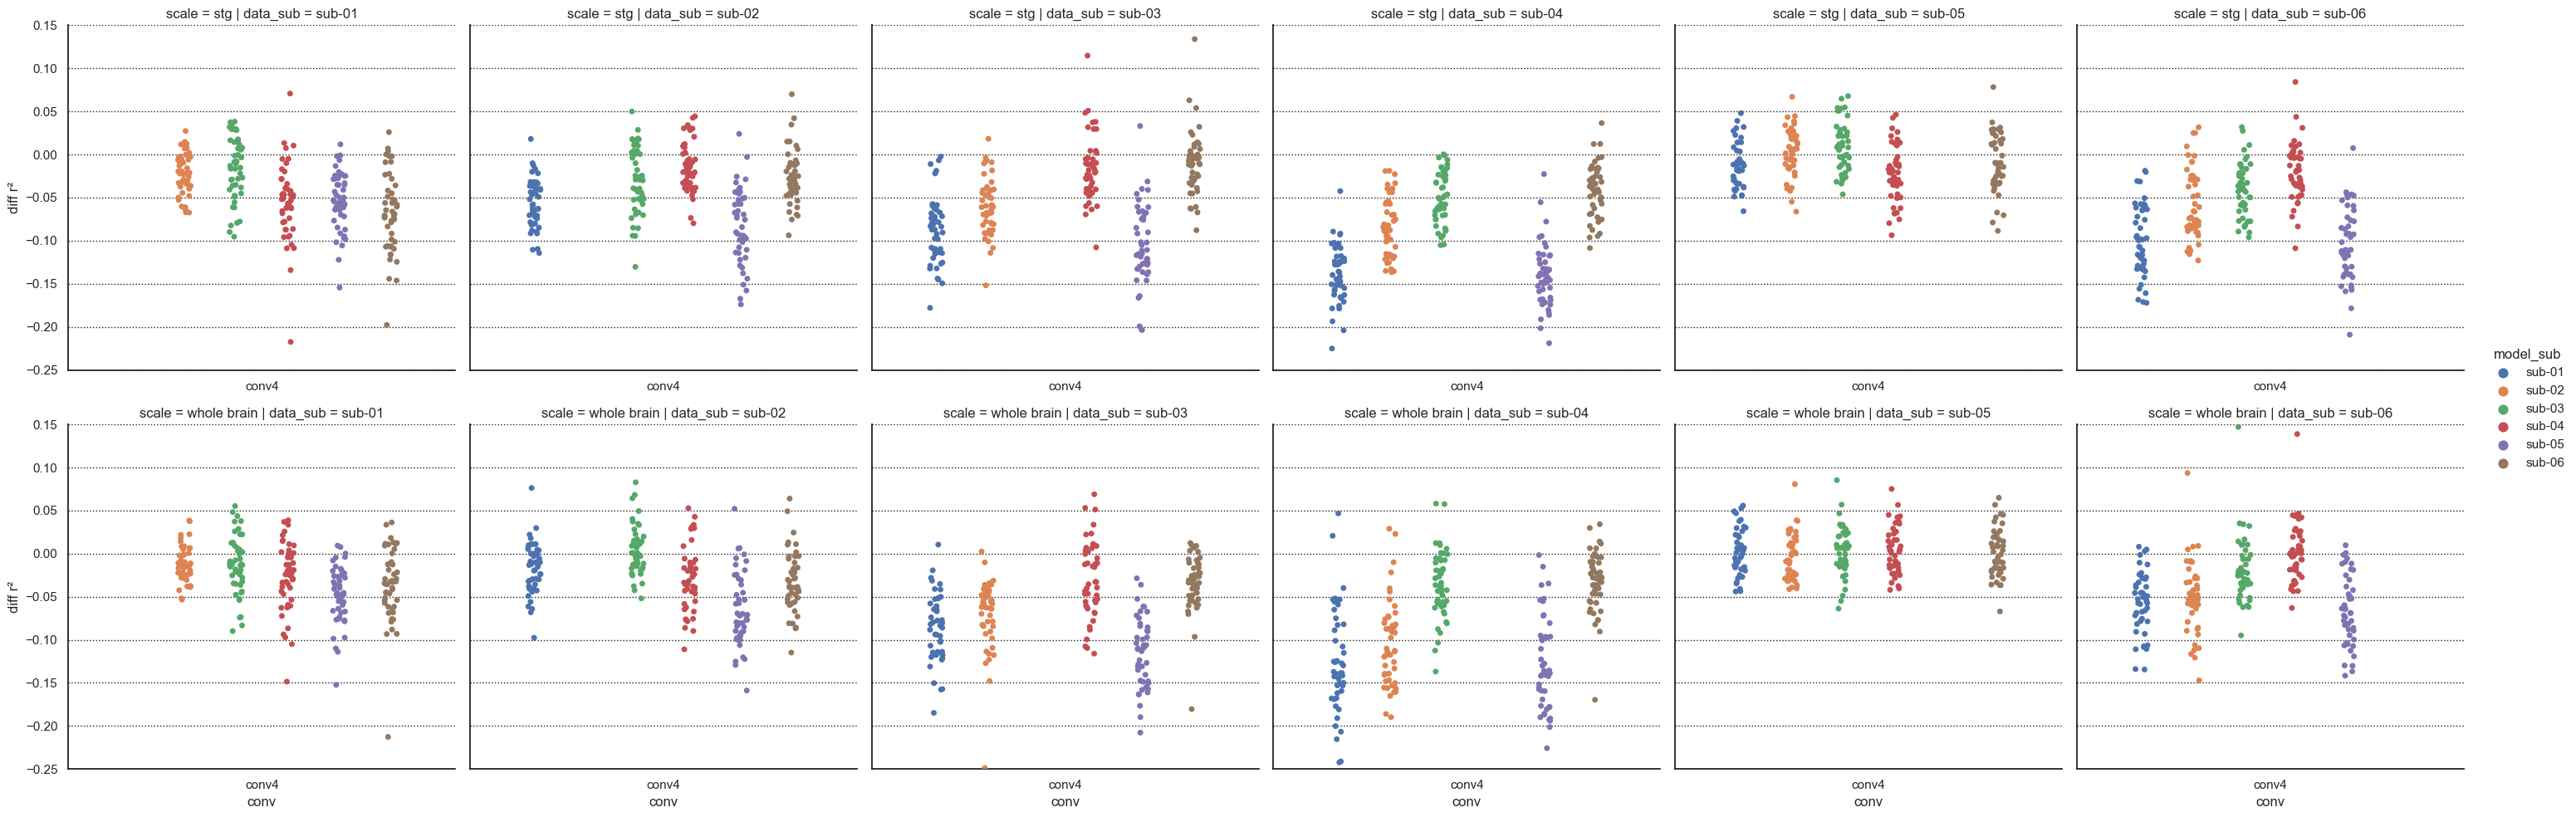

In [30]:
#sns.set_theme(context='poster', style='whitegrid', font_scale=2) 

sns.set(rc={'figure.figsize':(20,15), 'axes.facecolor':'w', 'axes.edgecolor': 'k', 
            'grid.color':'k', 'grid.linestyle': ':',})

dfconv = df.loc[df['conv']=='conv4'].copy()

print(dfconv)
g = sns.catplot(data=dfconv, x='conv', y='diff r²', hue='model_sub', col='data_sub', 
                row='scale', kind='strip', dodge=True,
                order=['conv4'], row_order=['stg', 'whole brain'], col_order=subs, hue_order=subs, sharex=False)
plt.ylim(bottom=-0.25, top=0.15)
sns.plotting_context()
g.savefig('/home/maelle/Results/figures/heareval/test_individual_spec.jpg') 